# End to End Machine learning project 

#### Data used : 
California Housing Prices dataset from the StatLib repository

# Project Checklist 

- [x] Frame the problem and look at the bigger picture
- [x] Get the Data
- [ ] Explore the Data to gain insights 
- [ ] Prepare the data to better expose the underlying data pattersn to ML algos
- [ ] Explore many different models and shortlist the best ones 
- [ ] Fine tune the model and combine them into a solution
- [ ] Present the solution
- [ ] Launch, monitor and maintain the system
  

# Problem statement : 

Welcome to the Machine Learning Housing Corporation! Your first task is to use California census data to build a model of housing prices in the state. This data includes metrics such as the population, median income, and median housing price for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). I will call them “districts” for short.
Your model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

# Getting the Data


Rather than manually downloading and decompressing the data, it’s usually preferable to write a function that does it for you. 
This is useful in particular if the data changes regularly: 

    - You can write a small script that uses the function to fetch the latest data (or you can set up a scheduled job to do that automatically at regular intervals). 
    
    - Automating the process of fetching the data is also useful if you need to install the dataset on multiple machines.

In [1]:
# Setting up the libraries 

# checking python version
import sys
assert sys.version_info >= (3, 7)

#checking scikit-learn version
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [3]:
# script to get and load the data 
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))


housing = load_housing_data()


# EDA

In [4]:
# Quick look at the data
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
# description of the data 
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- total_bedrooms attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature. Need to take care of this later.

In [6]:
# what categories exist and how many districts belong to each category by using the value_counts() method for ocean proxomity column:

housing['ocean_proximity'].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
# Decribe method shows a summary of the numerical attributes

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


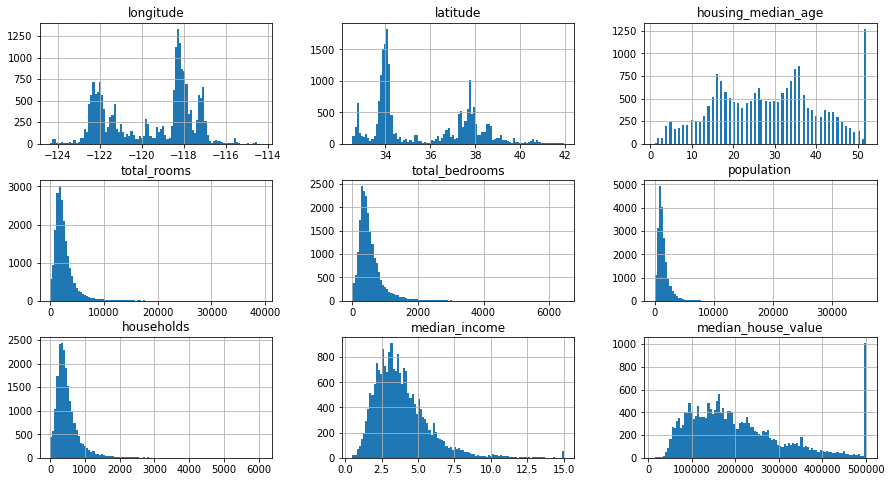

In [13]:
# A histogram shows the number of instances (on the vertical axis) 
# that have a given value range (on the horizontal axis). 
# You can either plot this one attribute at a time, or we can call the hist() method on the whole dataset 
# and it will plot a histogram for each *numerical attribute*

import matplotlib.pyplot as plt

housing.hist(bins=100, figsize=(15,8))
plt.show()

# Creating a test set 

In [14]:
import numpy as np

def shuffle_and_split_data(data , test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# generating the test and train set 

train_set , test_set  = shuffle_and_split_data(housing, 0.2)

print(F"Length train set : {len(train_set)}")
print(F"Length test set : {len(test_set)}")


Length train set : 16512
Length test set : 4128


### Uniqueness of test set 

Well, this works, but it is not perfect: if you run the program again, it will generate a different test set! Over time, you (or your machine learning algorithms) will get to see the whole dataset, which is what you want to avoid.

One solution is to save the test set on the first run and then load it in subsequent runs. Another option is to set the random number generator’s seed (e.g., with np.random.seed(42))6 before calling np.random.permutation() so that it always generates the same shuffled indices.

However, both these solutions will break the next time you fetch an updated dataset. 

To have a stable train/test split even after updating the dataset, a common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have unique and immutable identifiers). 

        For example, you could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value. 
        - This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. 
        - The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

In [15]:
# Implementation 


from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio)) 
    return data.loc[~in_test_set], data.loc[in_test_set] # "~" is a bitwise operator  NOT, which Inverts all the bits

# HOusing data doesnt have an identifier. 
# Use row index as id


housing_with_id = housing.reset_index()  # adds an `index` column
train_set , test_set = split_data_with_id_hash(housing_with_id, 0.2 , "index")


Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. 

The simplest function is train_test_split(), which does pretty much the same thing as the shuffle_and_split_data() function we defined earlier, with a couple of additional features. 

    - First, there is a random_state parameter that allows you to set the random generator seed. 
    - Second, you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices (this is very useful, for example, if you have a separate DataFrame for labels):


In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)